In [1]:
import importlib, yaml
import os, pandas as pd, numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
from sod.core import pdconcat
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
from sklearn.metrics import roc_curve
from itertools import cycle
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

print('loading source testset')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print('Columns')
print(allset_test.columns.tolist())

# Check duplicated rows (why do we have them? Who cares it does not affect evaluation metrics if we remove them):
prevlen = len(allset_test)
allset_test.drop_duplicates(subset=sod_core_dataset.allset_test.uid_columns, keep='first',
                            inplace=True)
if prevlen > len(allset_test):
    print()
    print('Dropped %d duplicated segments' % (prevlen - len(allset_test)))

# now plot classifiers:
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

print()
print('DONE')

loading source testset
Columns
['allset_test.id', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec', 'psd@5sec', 'psd@9sec', 'outlier', 'subclass', 'window_type', 'amplitude_ratio', 'event_id', 'station_id', 'event_time', 'channel_code', 'magnitude', 'distance_km', 'location_code']

Dropped 5694 duplicated segments

DONE


In [10]:
# Reading (creating) predictions on the test set instances

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/eval.allset_train_test.iforest.psd@5sec.n_estimators=50.yaml/'))
assert os.path.isdir(maindir)

# classifier names
names = [
    # 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=256&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=32768&n_estimators=50',
]
# check we did provide different file names:
assert len(set(names)) == len(names)


print('Reading the following classifiers (clf) with relative id (id: clf name):')
for i, n in enumerate(names):
    print('[%d]: %s' % (i, n))
clfs = [load(os.path.join(maindir, 'models', name+'.model')) for name in names]

print('Loading prediction dataframes')
maindir_preddf = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/eval.allset_train_test.iforest.psd@5sec.n_estimators=50.yaml/'))
assert os.path.isdir(maindir_preddf)
pred_dfs = [
    pd.read_hdf(os.path.join(_, 'predictions', name+'.hdf'))
    for _,name in zip(cycle([maindir_preddf]), names)
]

def dropdupes(dfr, *a, **kw):
    prevlen = len(allset_test)
    allset_test.drop_duplicates(subset=sod_core_dataset.allset_test.uid_columns, keep='first',
                            inplace=True)
    if prevlen > len(allset_test):
        print()
        print('Dropped %d duplicated segments' % (prevlen - len(allset_test)))


# Drop dupes. we do not need them and they might create confusion when merging with the event id:
allset_test.drop_duplicates(subset=sod_core_dataset.allset_test.uid_columns, keep='first',
                            inplace=True)
# Remove station with dataset_id = 2 and station_id=3258 (S1.AUTAR) as it was wrongly labelled.
# CHECK!!
allset_test = allset_test[(allset_test.dataset_id != 2) | (allset_test.station_id !=3258)].copy()
for i, pred_df in enumerate(pred_dfs):
    oldlen = len(pred_dfs[i])
    pred_dfs[i] = pred_df[(pred_df.dataset_id != 2) | (pred_df.station_id !=3258)].copy()
    assert len(pred_dfs[i]) == oldlen - 1325
    pred_dfs[i].drop_duplicates(subset=sod_core_dataset.allset_test.uid_columns, keep='first',
                                inplace=True)
    _pred_df = pred_dfs[i].merge(allset_test[list(sod_core_dataset.allset_test.uid_columns) + ['event_time']],
                                 how='left', on=list(sod_core_dataset.allset_test.uid_columns))
    assert 'event_time' in _pred_df.columns
    # print(_pred_df.columns.tolist())
    natimes = pd.isna(_pred_df.event_time).sum()
    if natimes:
        raise ValueError('%d NAT' % natimes)
    assert len(_pred_df) == len(pred_dfs[i])
    pred_dfs[i] = _pred_df
    

classnames = sod_core_dataset.allset_test.classnames
classes = {_: sod_core_dataset.allset_test.class_selector[_] for _ in classnames}
assert len(classes) == 3

labels = [int(clf.max_samples) for clf in clfs]
# or: # [int(re.match('.*max_samples=(\d+).*', _).group(1)) for _ in names]

def get_pred_df(index, *classindices):
    # label can be either 0: validation set inliers, 1: validation set outliers, 2: test set
    _df_ = pred_dfs[index]
    if not classindices:
        return _df_
    selector = None
    for classindex in classindices:
        _selector = classes[classnames[classindex]](_df_)
        if selector is None:
            selector = _selector
        else:
            selector |= _selector 
    return _df_[selector] 

from sklearn.metrics import precision_recall_fscore_support, auc, roc_curve, confusion_matrix

def get_cm(y_true, y_pred):
    labels = np.unique(y_true)
    auc_, best_th = None, None
    y_pred2 = y_pred
    if len(labels) == 2 and len(np.unique(y_pred)) != 2:
        fpr, tpr, th = roc_curve(y_true, y_pred)
        tnr = 1-fpr
        # find best thresold:
        argmax = np.argmax((tnr + tpr))  # we should write 0.5 * (tnr+tpr) but fro finding the max it's the same 
        best_th = th[argmax]
        y_pred2 = np.zeros(len(y_true), dtype=int)
        y_pred2[y_pred>=best_th] = 1
        auc_ = auc(fpr, tpr)
    
    p, r, f, n = precision_recall_fscore_support(y_true, y_pred2, labels=labels)
    cm_ = confusion_matrix(y_true, y_pred2, labels=labels)
    data = [np.append(row, [n[i], r[i], p[i], f[i]]) for i, row in enumerate(cm_)]
    data.append([''] * len(labels) + [np.sum(n), np.nanmean(r), np.nanmean(p), np.nanmean(f)])

    cm = pd.DataFrame(index=['[%s]' % str(_) for _ in labels] + ['Mean (Sum for "N") ->'],
                      columns=['cl.as[%s]' % str(_) for _ in labels] + ['N', 'R', 'P', 'F1'],
                      data=data
                     )
    return auc_, best_th, cm
    
print()  
print('Calculating some metrics and setting some stuff for better memory management')
# print('Setting scores with offset and normalization (columns score_samples_offset_only and score_samples)')
vset_metrics_columns = ['auc', 'logloss_outliers', 'best threshold']
vset_metrics = pd.DataFrame(index=range(len(clfs)), columns=vset_metrics_columns)

maxima, minima = [], []
vset_cms = []

# setting stuff:
for idx, pred_df in enumerate(pred_dfs):
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    
    # get best threhold, calcuated from validation set only (inliers + outliers, no Me unknown):
    pred_df_outl_inl_only = get_pred_df(idx, 0, 1)
    auc_, best_th, cm = get_cm(pred_df_outl_inl_only.outlier, pred_df_outl_inl_only.predicted_anomaly_score)

#     scores = np.copy(pred_df.predicted_anomaly_score.values)
    
#     # offset: ====================
#     scores += 0.5 - best_th
#     # ============================
#     pred_df['score_samples_offset_only'] = np.copy(scores)
    
#     # adjust: ====================
#     _max = np.nanmax(scores)
#     scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
#     # ============================
#     pred_df['score_samples'] = scores
    
    maxima.append(np.nanmax(pred_df.predicted_anomaly_score.values))
    maxima.append(np.nanmin(pred_df.predicted_anomaly_score.values))
    
    # compute metrics:
    vset_metrics.at[idx, vset_metrics_columns[0]] = auc_
    vset_metrics.at[idx, vset_metrics_columns[1]] = sod_core_eval.log_loss(get_pred_df(idx, 1))
    vset_metrics.at[idx, vset_metrics_columns[2]] = best_th
    vset_cms.append(cm)


print()
print('Confusion matrices per best threshold')
best_thresholds = vset_metrics[vset_metrics_columns[2]].values
for i, (cm, best_th) in enumerate(zip(vset_cms, best_thresholds)):
    print()
    print('[%s]: best threshold: %f. Confusion matrix:\n%s' % (labels[i], best_th, cm.to_string()))

print()
print('Validation set Metrics')
print(vset_metrics.to_string())

# define the scores function
def score_samples(clf_index, psds, offset=True, normalize=True):
    clf = clfs[clf_index]
    best_thresholds = vset_metrics[vset_metrics_columns[2]].values
    scores = -clf.score_samples(psds.reshape((len(psds), 1)))
    if offset:
        scores += 0.5 - best_thresholds[clf_index]
    if normalize:
        _max = maxima[clf_index]
        scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    return scores

print()
print('Prediction dataframe  (testsets and valsets) columns:')
print(pred_df.columns.tolist())
print('DONE')

Reading the following classifiers (clf) with relative id (id: clf name):
[0]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=256&n_estimators=50
[1]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50
[2]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50
[3]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50
[4]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50
[5]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50
[6]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=50
[7]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=32768&n_estimators=50
Loading prediction dataframes

Calculating some metrics and setting some stuff for bett

Comparing models (clfs) scores:
Above main diagonal: maxima, below main diagonal: median
      0     1     2     3     4     5     6     7
0   NaN  0.06  0.08  0.12  0.14  0.15  0.16  0.17
1  0.03   NaN  0.05  0.08  0.11  0.12  0.13  0.15
2  0.04  0.01   NaN  0.05  0.08  0.11  0.12  0.15
3  0.06  0.04  0.03   NaN  0.05  0.08  0.09  0.13
4  0.06  0.03  0.02  0.00   NaN  0.06  0.07  0.11
5  0.07  0.04  0.03  0.01  0.01   NaN  0.05  0.09
6  0.04  0.01  0.01  0.03  0.02  0.03   NaN  0.06
7  0.03  0.02  0.02  0.04  0.04  0.04  0.01   NaN


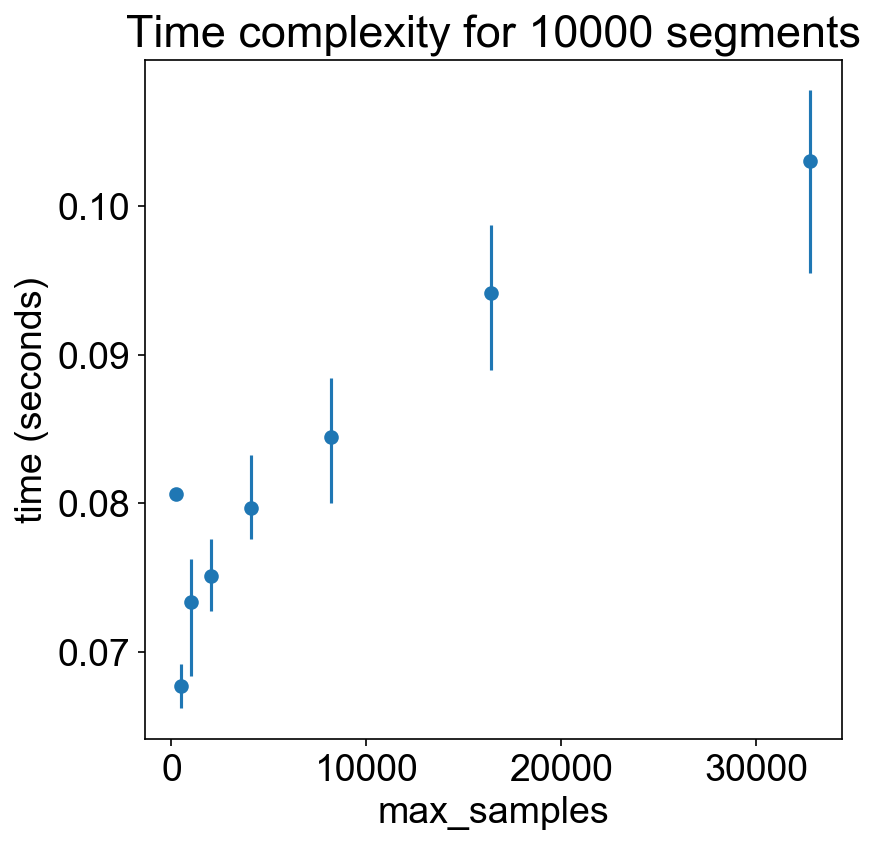

DONE


In [3]:
import time
bins = np.arange(-200, 100, 0.03)
print('Comparing models (clfs) scores:')
print('Above main diagonal: maxima, below main diagonal: median')
indices = list(range(len(clfs)))
dfr = pd.DataFrame(index=indices, columns=indices, data=np.nan)
times = [[] for _ in range(len(clfs))]
for i in indices:
    clf1 = i
    t = time.time()
    scores1 = score_samples(i, bins, False, False)
    t = time.time() - t
    times[i].append(t)
    for j in indices:
        if i >= j:
            continue
        clf2 = j
        t = time.time()
        scores2 = score_samples(j, bins, False, False)
        t = time.time() -t
        times[j].append(t)
        _diffs = np.abs(np.diff(np.array([scores1, scores2]), axis=0))[0]
        dfr.at[i, j] = np.round(np.max(_diffs),2)
        dfr.at[j, i] = np.round(np.median(_diffs),2)

print(dfr.to_string())

import re

with plotparams({'figure.figsize': (6, 6), 'font.size': 18, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    x = labels
    y = np.array([np.nanmean(_) for _ in times])
    yerr = [np.abs(y-[np.nanmin(_) for _ in times]), np.abs(y-[np.nanmax(_) for _ in times])]
    plt.errorbar(x, y, yerr=yerr, marker='o', linestyle='None')
    plt.ylabel('time (seconds)')
    plt.xlabel('max_samples')
    plt.title('Time complexity for %d segments' % len(bins))
    plt.show()


del dfr
print('DONE')



In [4]:
import numpy as np
print('Smoothness (rough estimation: the lower, the scores time series is smoother)')
bins_psd = np.arange(-250, 100, 0.01)
psdvalues = [score_samples(i, bins_psd, False, False) for i in range(len(names))]
for k, val in enumerate(psdvalues):
    prevdiff = val[1] - val[0]
    c = 0
    for i in range(2, len(val)):
        currdiff = val[i] - val[i-1]
        if currdiff*prevdiff < 0:
            c += 1
        prevdiff = currdiff
    score_ = c / float(len(val)-1)
    print("CLF [%d]: %f" % (k, score_))
        

Smoothness (rough estimation: the lower, the scores time series is smoother)
CLF [0]: 0.009486
CLF [1]: 0.018229
CLF [2]: 0.033715
CLF [3]: 0.051830
CLF [4]: 0.070088
CLF [5]: 0.088260
CLF [6]: 0.109917
CLF [7]: 0.129032


Calculating scores on a psd(5seconds) range
Plotting classifiers by n_estimators



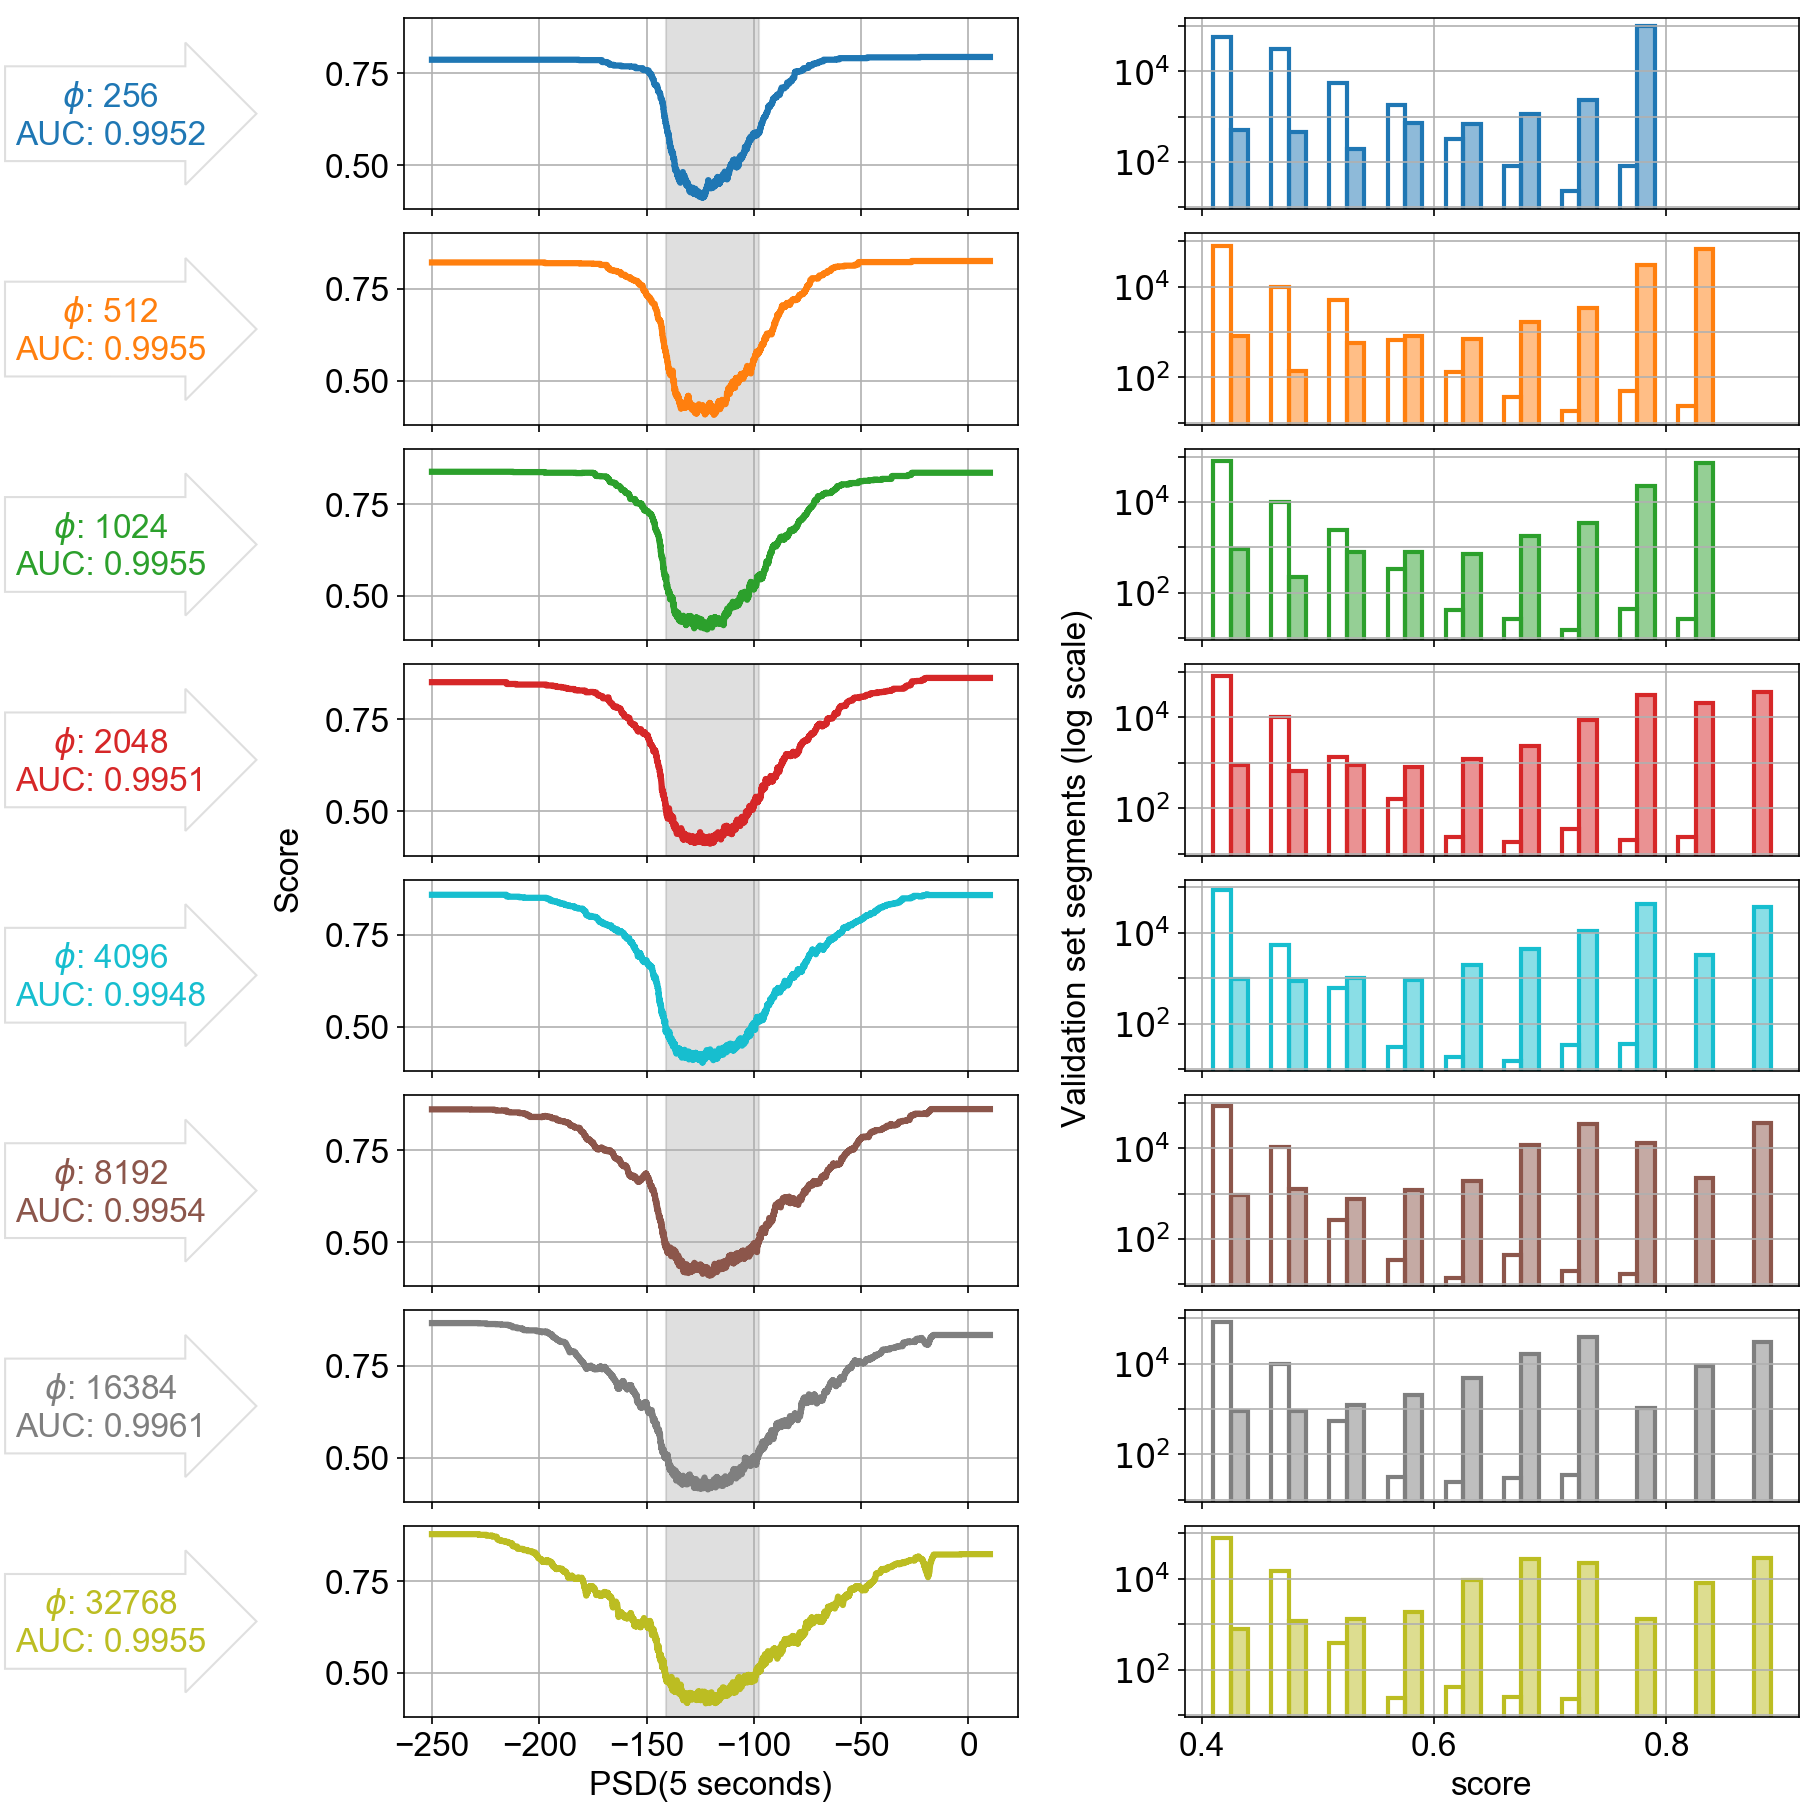

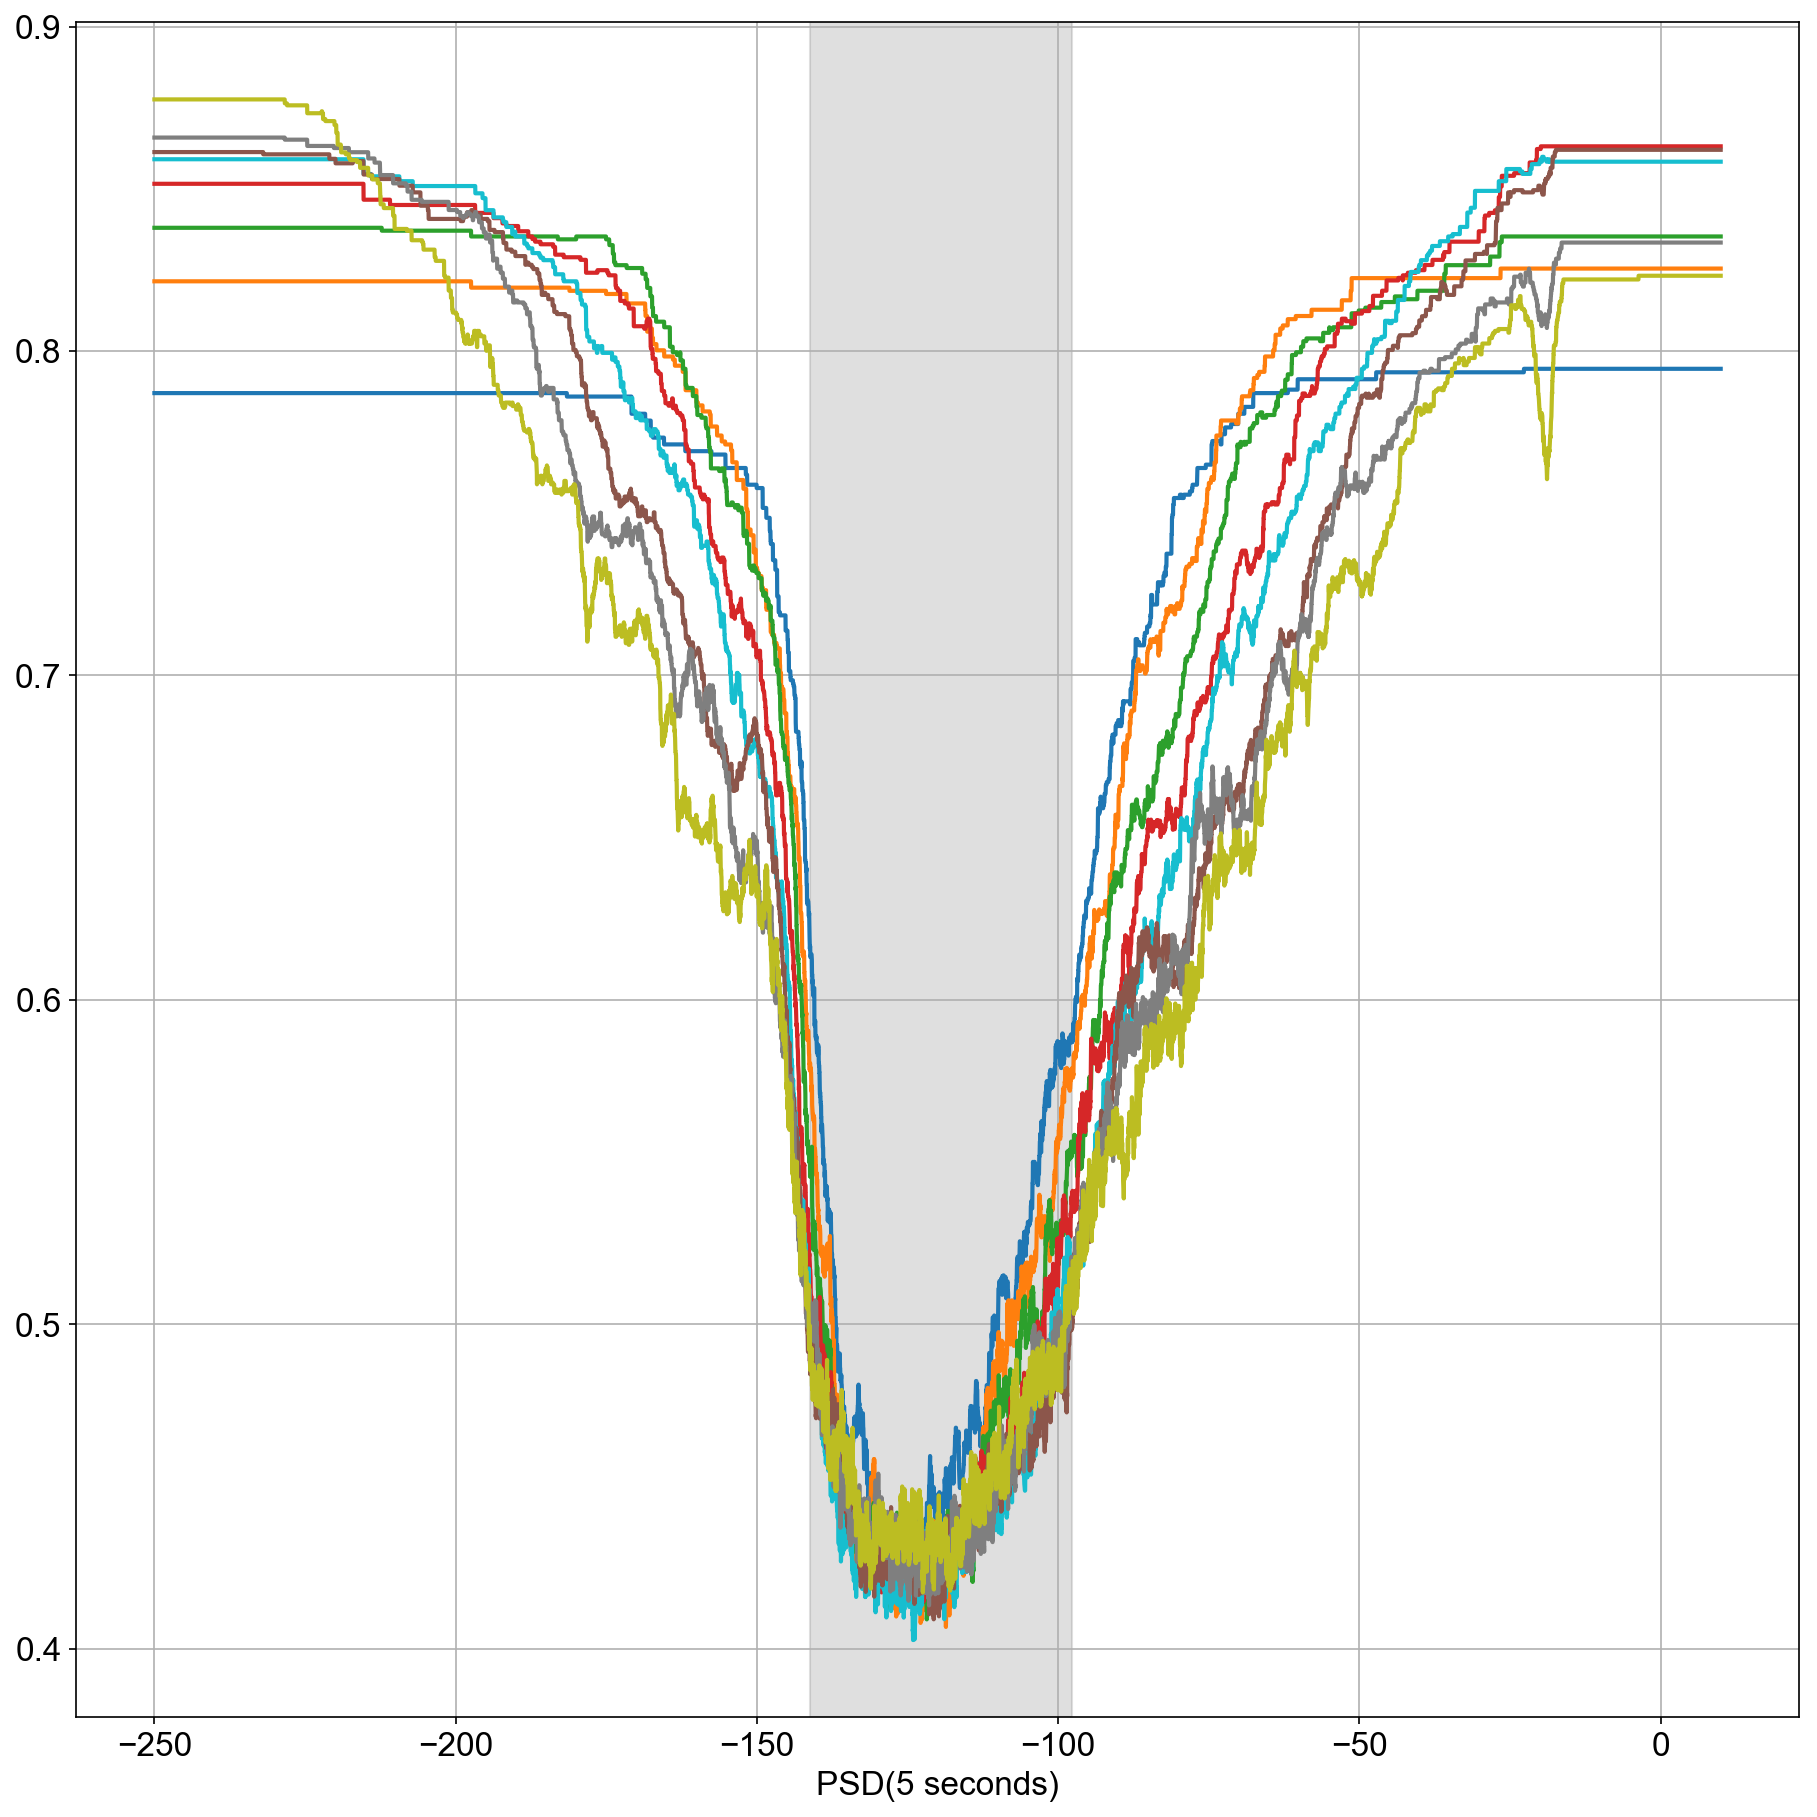

In [5]:
from itertools import chain
from matplotlib.colors import to_rgba

# now plot classifiers:
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v


from obspy.signal.spectral_estimation import get_nlnm, get_nhnm
def get_petterson_bounds(periods):
    l_periods, l_psd = get_nlnm()
    h_periods, h_psd = get_nhnm()
    periodz = np.log10(periods)
    return np.interp(periodz, np.log10(l_periods[::-1]), l_psd[::-1]), \
        np.interp(periodz, np.log10(h_periods[::-1]), h_psd[::-1]) 
            
            
bins_psd = np.arange(-250, 10, 0.025)
bins_scores = np.arange(0.4, 0.95, 0.05)
bins_score_ticks = bins_scores[::4]

print('Calculating scores on a psd(5seconds) range')
data = [
    [clfs[i], score_samples(i, bins_psd, False, False),
     get_pred_df(i, 0).predicted_anomaly_score.values,  # inliers
     get_pred_df(i, 1).predicted_anomaly_score.values,  # outliers
    ] for i in range(len(clfs))
]


ticks = [0, .25, .5, .75, 1]

def setlim(axes, x=True, y=True):
    minx, maxx, miny, maxy = np.inf, -np.inf, np.inf, -np.inf
    for ax in axes:
        minx = min(ax.get_xlim()[0], minx)
        maxx = max(ax.get_xlim()[1], maxx)
        miny = min(ax.get_ylim()[0], miny)
        maxy = max(ax.get_ylim()[1], maxy)
    for ax in axes:
        if x:
            ax.set_xlim(minx, maxx)
        if y:
            ax.set_ylim(miny, maxy)
    if x and y:
        return minx, maxx, miny, maxy
    elif x:
        return minx, maxx
    elif y:
        return miny, maxy
    else:
        raise ValueError('x and y can not be both False')

        
# The plots below ASSUME there the set of unique n_estimators is 3 for all classifiers involved
# Max samples (the number of lines per plot) can be given here:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:cyan', 'tab:brown', 'tab:gray', 'tab:olive']
assert len(labels) == len(colors)

N = len(colors)

print('Plotting classifiers by n_estimators')
print()

with plotparams({'figure.figsize': (12, 12), 'font.size': 16, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    #heights = [2] * (2*len(colors))
    #heights[::2] = [1] * len(colors)
    gs = fig.add_gridspec(N, 5,
                          #height_ratios=heights,
                          width_ratios=[10, 1, 50, 1, 50])
    
    # PLOT MIDDLE PLOT: IT IS A DUMMY PLOT HOLDING ONLY A SHARED y LABEL
    for i, lbl in enumerate(['Score', 'Validation set segments (log scale)']):
        ax = fig.add_subplot(gs[:, 1+2*i])
        ax.set_ylabel(lbl)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.yaxis.set_label_position("right")

    aucs_ = vset_metrics[vset_metrics.columns[0]].values
    for j, color in enumerate(colors):
        ax = fig.add_subplot(gs[j, 0])
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_yaxis().set_ticks([])
        bbox_props = dict(boxstyle="rarrow", lw=1, fc='white', ec="0.5", alpha=0.25)  # fc='white', ec="0.01",  pad=0.6)
        t = ax.text(0, 0.5, '$\phi$: %d\nAUC: %.4f' % (labels[j], aucs_[j]), color=color,
                    ha='center', va='center', bbox=bbox_props)
        bb = t.get_bbox_patch()
        # bb.set_boxstyle("rarrow", pad=0.6)
    
#     # PRINT TOP BAR. IT's A PLOT, BUT IT CONTAINS JUST THE LEGENDS
#     data_slice = data
#     titles = set([d[0].n_estimators for d in data_slice])
#     assert len(titles) == 1
#     row_index = 0
#     ax = fig.add_subplot(gs[row_index, :])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     # comment this if you want to place title and legend:
#     # ax.axis('off')
#     ax.set_xlim([0, 1])
#     ax.set_ylim([0, 1])
# #         ax.text(0.5, 0.5, 'Classifiers with n_estimators=%d and max_samples:' % list(titles)[0],
# #                 ha='left', va='bottom')
#     # dummy bars with width=height=0 just to show the legend
#     for d, color in zip(data_slice, colors):
#         ax.bar([0],[0], color=color, label=str(d[0].max_samples))
#     # place legend: bbox_to_anchor is a 2-tuple (x, y) places the corner of the legend specified
#     # by `loc` at x, y: REMEBER THAT on the Y, 0 is LOWER THAN 1
# #         ax.legend(loc='upper left', ncol=NUM_MAX_SAMPLES*2, bbox_to_anchor=(0, 0.5), frameon=False)
#     # ax.set_title('Classifiers with n_estimators=%d' % list(titles)[0], loc='center')
        
    # left side axes (scores)
    axs_ = []
    for j, color in enumerate(colors):
        ax = fig.add_subplot(gs[j, 2])
        axs_.append(ax)
        ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray',
           label='Noise model bounds (Peterson, 93)')
        d = data[j]
        ax.plot(bins_psd, d[1], label='max_samples: %d' % d[0].max_samples, linewidth=3, color=color)
#         for d, color in zip(data_slice, colors):
#             ax.plot(bins_psd, d[1], label='max_samples: %d' % d[0].max_samples, linewidth=3, color=color)
        if j < N-1:
            ax.get_xaxis().set_ticklabels([])
        else:
            ax.set_xlabel('PSD(5 seconds)')
        # ax.set_xlabel('PSD(5 seconds)')
        # ax.set_ylabel('score')
        # ax.legend()
        # ax.set_title('max_samples=%d' % labelz[j])
        ax.grid()
    setlim(axs_, x=True, y=True)

    axs_ = []
    
    data_slice = data
    # testset_scores = [d[2] for d in data_slice]
    for j, color in enumerate(colors):
        ax = fig.add_subplot(gs[j, 4])
        axs_.append(ax)
        testset_inliers_scores = data_slice[j][2]
        testset_outliers_scores = data_slice[j][3]
#         ax.hist(testset_inliers_scores,
#                 bins=bins_scores, label=clf_labels[j],
#                 stacked=False, log=True,
#                 histtype='bar', linewidth=3, align='mid'
#                 , rwidth=0.75, color='white', edgecolor=color,
#                )
#         ax.hist(testset_outliers_scores,
#                 bins=bins_scores, label=clf_labels[j],
#                 stacked=False, log=True,
#                 histtype='bar', linewidth=3, align='mid'
#                 , rwidth=0.75, color=color, edgecolor='white',
#                )
        alphacolor = list(to_rgba(color))
        alphacolor[-1] = 0.5
        ax.hist([testset_inliers_scores, testset_outliers_scores],
                bins=bins_scores, label=[labels[j], labels[j]],
                stacked=False, log=True,
                histtype='bar', linewidth=2, align='mid'
                , rwidth=0.6, color=['white', alphacolor], edgecolor=color
               )
        # ax.set_ylabel('test set segments')
        # ax.set_xlabel('score')
        ax.set_xticks(bins_score_ticks)
        # set xlabel only on bottom plot:
        if j < N-1:
            ax.get_xaxis().set_ticklabels([])
        else:
            ax.set_xlabel('score')
        #ax.get_yaxis().set_visible(False)
        # ax.legend()
        # ax.set_title('max_samples=%d' % labelz[j])
        ax.grid()
    setlim(axs_, x=True, y=True)
    for ax in axs_:
        ax.set_yticks([10, 100, 1000, 10000, 100000])
        ax.set_yticklabels(['', '$10^2$', '', '$10^4$', ''])
        

    # plt.tight_layout()
    plt.show()
    
    
    
    # show all time series on the same plot
with plotparams({'figure.figsize': (12, 12), 'font.size': 16, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(1, 1)
                            #,
                          #height_ratios=heights,
                          # width_ratios=[10, 1, 50, 1, 50])
    ax = fig.add_subplot(gs[0, 0])
    ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray',
           label='Noise model bounds (Peterson, 93)')
    for j, color in enumerate(colors):
        # axs_.append(ax)
        d = data[j]
        ax.plot(bins_psd, d[1], label='%d' % d[0].max_samples, linewidth=2, color=color)
#         for d, color in zip(data_slice, colors):
#             ax.plot(bins_psd, d[1], label='max_samples: %d' % d[0].max_samples, linewidth=3, color=color)
#         if j < N-1:
#             ax.get_xaxis().set_ticklabels([])
#         else:
        ax.set_xlabel('PSD(5 seconds)')
        # ax.set_xlabel('PSD(5 seconds)')
        # ax.set_ylabel('score')
        # ax.legend()
        # ax.set_title('max_samples=%d' % labelz[j])
    ax.grid()
    # ax.legend()

In [11]:
# plotting misclassified channels
import csv

# print('Adding event time to prediction dataframes')
# timin, tmax = None, None
# for i, pred_df in enumerate(pred_dfs):
    
#     assert 'event_time' not in pred_df.columns
#     _pred_df = pred_df.merge(allset_test[['allset_test.id', 'dataset_id', 'event_time']],
#                              how='left', on=['allset_test.id', 'dataset_id'])
#     assert 'event_time' in _pred_df.columns
#     # print(_pred_df.columns.tolist())
#     natimes = pd.isna(_pred_df.event_time).sum()
#     if natimes:
#         raise ValueError('%d NAT' % natimes)
#     print(len(pred_df))
#     print(len(_pred_df))
    
#     assert len(_pred_df) == len(pred_df)
#     pred_dfs[i] = _pred_df.copy()

#     _tmin, _tmax = pd.to_datetime(_pred_df.event_time.min()), pd.to_datetime(_pred_df.event_time.max())
#     if i == 0 or _tmin < tmin:
#         tmin = _tmin
#     if i==0 or _tmax > tmax:
#         tmax = _tmax

# print('Event times (min, max): %s, %s' % (str(tmin), str(tmax)))

print('Getting station networks and stations (querying source databases)')
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dataset_urls= {
    1: jnconfig['dbpath_new'],
    2: jnconfig['dbpath_me'],
    3: jnconfig['dbpath_chile']
}


station_codes = {}

from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv

for dts_id, df in pred_dfs[0].groupby('dataset_id'):  # use just one prediction dataframe, the first
    sess = get_session(dataset_urls[dts_id])
    for (staid, stanet, stasta) in sess.query(Station.id, Station.network, Station.station):
        station_codes[(dts_id, staid)] = "%s.%s" % (stanet, stasta)
    sess.close()


print('DONE')

Getting station networks and stations (querying source databases)


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


DONE


In [13]:
print('Creating dictionaries of predictions on a per station basis with prediction scores mapped to event times')
columns = ['dataset_id', 'station_id', 'cha_id', 'location_code']

data_predicted = {}
from collections import defaultdict


for iii in range(len(clfs)):
    pred_df = get_pred_df(iii, 2)
    for (dts_id, sta_id, cha_id, loc_code), df in pred_df.groupby(columns):

        channel = '%s.%s.%s?' % (station_codes[(dts_id, sta_id)], loc_code, cha_id)
        key = (int(sta_id), int(dts_id), channel)

        if key in data_predicted:
            _plot = data_predicted[key]
        else:
            _plot = {
                'channel': channel,
                'num_segments': len(df),
                'dataset_name': dataset_urls[dts_id][dataset_urls[dts_id].rfind('/')+1:],
                'dataset_id': dts_id,
                'station_id': sta_id,
                'scores': [None for _ in names]
            }
            data_predicted[key] = _plot

        _plot['scores'][iii] = df[['event_time', 'predicted_anomaly_score']]

print('DONE')

Creating dictionaries of predictions on a per station basis with prediction scores mapped to event times
DONE


In [32]:
print('Comparing with annotated labels using IF raw scores')
            
from datetime import datetime, timedelta
# datetime.strptime("2010-06-04 21:08:12", "%Y-%m-%d %H:%M:%S")
time0 = datetime(year=1970, month=1, day=1) - timedelta(days=1)
time1 = datetime(year=2260, month=1, day=1) + timedelta(days=1)  # https://stackoverflow.com/a/37226672

# process only csv rows with this value of 'label':
filter_labels = ['unlabeled (Me unknown)']
print('Using only csv labels: %s' % filter_labels)

min_psd5scores = [np.nanmin(score_samples(i, np.arange(-150, -100, 0.01), False, False)) for i in range(len(clfs))]
max_psd5scores = [np.nanmax(score_samples(i, np.arange(-10000, 100000, 1), False, False)) for i in range(len(clfs))]

print('Minima and maxima scores (computed on a range of PSD values)')
for i in range(len(min_psd5scores)):
    print('CLF [%d]: %f %f' % (i, min_psd5scores[i], max_psd5scores[i]))

print()
print('Comparing prediction with labels')
from sklearn.metrics import mean_squared_error as MSE
# map each classifier index to the tuplke (sum_of_mse, number_of_instances)
# this is why MSE multuoutput 'raw_values' seems not to work (it returns the average. WHY???)
mean_squared_errors = [[0, 0] for _ in names]

csvpath = '/Users/riccardo/Nextcloud/rizac_docs/plot.misclassified.final.csv'

labelled_test_df = [[] for _ in range(len(clfs))]

suspicious_annotated_ids = set()
# store ids of station used (see below)
used_sta_ids = []
with open(csvpath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['label'] not in filter_labels:
            continue
        try:
            id_ = (int(row['station_id']), int(row['dataset_id']), row['channel'])
            used_sta_ids.append(id_[0])
            annotated_score = float(row['score_d'])
            start_time = time0 if not row['start_time'] else datetime.strptime(row['start_time'], "%Y-%m-%d")
            end_time = time1 if not row['end_time'] else datetime.strptime(row['end_time'], "%Y-%m-%d")            
        except ValueError:
            print('Parsing error in date or scores or ids: Skipping station_id=%s (dataset_id=%s), channel=%s' %
                  (row['station_id'], row['dataset_id'], row['channel']))
            continue

        # try to parse also second annotator:
        try:
            annotated_score = 0.5 * (annotated_score * float(row['score_a']))
        except (ValueError, TypeError):
            pass
        
        # fetch data predicted:
        data_pred = data_predicted[id_]
        # print(data_pred)
        zcores = data_pred['scores']
        for clf_idx, _df_ in enumerate(zcores):
            
            # create dataframe with times and predictions:
            _df_with_matching_events = _df_[(_df_.event_time > start_time) & (_df_.event_time < end_time)]
            y_pred = _df_with_matching_events['predicted_anomaly_score'].values
            
            labelled_test_df[clf_idx].append(pd.DataFrame({'outlier': [annotated_score] * len(y_pred),
                                                           'predicted_anomaly_score': y_pred}))
            
            # heuristic check (just to confirm the annotations):
            if annotated_score == 1 and np.any(y_pred <= 0.5) and id_ not in suspicious_annotated_ids:
                suspicious_annotated_ids.add(id_)
                print('%s: has outliers with score <= 0.5 in range [%s, %s]' %
                                 (str(id_), str(row['start_time']), str(row['end_time'])))
            if annotated_score == 0 and np.any(y_pred >= 0.8) and id_ not in suspicious_annotated_ids:
                suspicious_annotated_ids.add(id_)
                print('%s: has inliers with score >=0.8 in range [%s, %s]' %
                                 (str(id_), str(row['start_time']), str(row['end_time'])))

                
# create a set of unknown segments to populate the test dataframes:
# IN PRINCIPLE, they are inliers:
u_pred_dfs = []
for i in range(len(labelled_test_df)):
    df_ = get_pred_df(i, 2)
    u_pred_dfs.append(df_[~df_.station_id.isin(used_sta_ids)])

    
# _selector = classes[classnames[2]](allset_test)
# unused_unknown_segments =  allset_test[_selector].copy()
# unused_unknown_segments = \
#             unused_unknown_segments[~unused_unknown_segments.station_id.isin()
#             ].copy()

# normalize newscores:
for i in range(len(labelled_test_df)):
    labelled_test_df[i] = pd.concat(labelled_test_df[i], sort=False, axis=0, copy=True)

from sklearn.metrics import roc_curve, auc
print()
print('Metrics (details):')

auc_scores = pd.DataFrame(index=labels, columns=['AUC[ALLvs1]', 'AUC[0vs0.5]', 'Avg', 'W.Avg'])
f1_scores = pd.DataFrame(index=labels,columns=['F1[ALLvs1]', 'F1[0vs0.5]', 'Avg', 'W.Avg'])
# thresholds_ = [[0,0] for _ in range(len(names))]

ys = []

auc_scores = pd.DataFrame(columns=['Vset AUC[0vs1]', 'Tset AUC[ALLvs1]', 'Tset AUC[ALLvs0]', 'Avg', 'W.Avg'])
f1_scores = pd.DataFrame(columns=['Vset F1S[0vs1]', 'Tset F1S[ALLvs1]', 'Tset F1S[ALLvs0]', 'Avg', 'W.Avg'])
th_scores = pd.DataFrame(columns=['Vset TH[0vs1]', 'Tset TH[ALLvs1]', 'Tset TH[ALLvs0]'])

for i, _score_df in enumerate(labelled_test_df):
    y_ = []
    
    test_labels = np.copy(labelled_test_df[i].outlier.values)
    test_predictions = np.copy(labelled_test_df[i].predicted_anomaly_score.values)
 
    # Val.set:
    cm_1 = vset_cms[i]
    auc_1 = vset_metrics[vset_metrics.columns[0]].values[i]
    best_th_1 = vset_metrics[vset_metrics.columns[2]].values[i]
#     print()
#     print()
#     print('ValSet for CLF[%d]: max_samples=%d 0vs1' % (i, labels[i]))
#     print('Class 0: inliers, Class 1: outliers')
#     print(cm_1.to_string())
#     print('th: %f' % best_th_1)
#     print('AUC: %f' % auc_1)
    
    # now find best threshold on the test set. Use also outliers of the validation set
    # (ONLY TO FIND THE THRESHOLD) in order to ahve a more generalized specturm of outliers
    # (wrong inv)
    _vset_outliers_predictions = get_pred_df(i,1).predicted_anomaly_score.values
    test_predictions_th = np.append(test_predictions, _vset_outliers_predictions)
    test_labels_th = np.append(test_labels, np.ones(len(_vset_outliers_predictions)))
    assert np.sum(test_labels_th) == np.sum(test_labels) + len(_vset_outliers_predictions)
    # there are more outliers than inliers, thus add inliers from the unlabelled data:
    n_missing_inliers = np.sum(test_labels_th>=1) - np.sum(test_labels_th<1)
    test_predictions_th = np.append(test_predictions_th,
                                    u_pred_dfs[i].sample(n_missing_inliers, random_state=43).predicted_anomaly_score.values)
    print('MI: %d' % n_missing_inliers)
    test_labels_th = np.append(test_labels_th,
                               np.zeros(n_missing_inliers))
    assert len(test_predictions_th) == len(test_labels_th)
    
    
    test_labels_th[test_labels_th < 1] = 0
    _, best_th_2, _ = get_cm(test_labels_th, test_predictions_th)
    
    # ALL vs 1
    print()
    print('TestSet for CLF[%d]: max_samples=%d ALLvs1 and BEST THRESHOLD: %f' % (i, labels[i], best_th_2))
    y_pred = np.copy(test_predictions_th >= best_th_2)
    y_true = np.copy(test_labels_th >= 1)
    assert len(y_pred) == len(y_true)
    auc_2, _, cm_2 = get_cm(y_true, y_pred)
    print('Class 0: inliers+unknown, Class 1: outliers')
    print(cm_2.to_string())
    print('th: %f' % best_th_2)
    print('AUC: None')
    
    
#     # ALL vs 1
#     print()
#     print('TestSet for CLF[%d]: max_samples=%d ALLvs1 and BEST THRESHOLD: %f' % (i, labels[i], best_th_2))
#     y_pred = np.copy(test_predictions >= best_th_2)
#     y_true = np.copy(test_labels >= 1)
#     assert len(y_pred) == len(y_true)
#     auc_2, _, cm_2 = get_cm(y_true, y_pred)
#     print('Class 0: inliers+unknown, Class 1: outliers')
#     print(cm_2.to_string())
#     print('th: %f' % best_th_2)
#     print('AUC: None')
    
#     # ALL vs 1
#     print()
#     print('TestSet for CLF[%d]: max_samples=%d ALLvs1' % (i, labels[i]))
#     y_pred = np.copy(test_predictions)
#     y_true = np.copy(test_labels >= 1)
#     assert len(y_pred) == len(y_true)
#     auc_2, best_th_2, cm_2 = get_cm(y_true, y_pred)
#     print('Class 0: inliers+unknown, Class 1: outliers')
#     print(cm_2.to_string())
#     print('th: %f' % best_th_2)
#     print('AUC: %f' % auc_2)
    
#     # 0 vs 0.5
#     print()
#     print('TestSet for CLF[%d]: max_samples=%d TH=0.5' % (i, labels[i]))
#     # make predictions binary: 1 for values higher than 0.5, 0 otherwise
#     y_pred = np.copy(test_predictions >= 0.5)
#     # make labels binary: 0 for 0, 1 for others
#     y_true = np.copy(test_labels > 0)
#     assert len(y_pred) == len(y_true)
#     auc_3, best_th_3, cm_3 = get_cm(y_true, y_pred)
#     print('Class 0: inliers, Class 1: unknown+outliers')
#     print(cm_3.to_string())
#     # print('th: %f' % best_th_3)
#     # print('AUC: %f' % auc_3)
    
    f1_scores.at[labels[i], f1_scores.columns[0:3]] = [cm_1.values[-1][-1], cm_2.values[-1][-1], cm_3.values[-1][-1]]
    auc_scores.at[labels[i], auc_scores.columns[0:3]] = [auc_1, auc_2, auc_3]
    th_scores.at[labels[i], th_scores.columns[0:3]] = [best_th_1, best_th_2, best_th_3]
    
    
    print()
    print()

print()
print('====================================')
    
auc_scores['Avg'] = auc_scores.mean(axis=1)
auc_scores['W.Avg'] = (
    1*auc_scores[auc_scores.columns[0]] +
    1*auc_scores[auc_scores.columns[1]] +
    0*auc_scores[auc_scores.columns[2]]) /2.0
print()
print('AUC scores of different models')
print(auc_scores.to_string())

f1_scores['Avg'] = f1_scores.mean(axis=1)
f1_scores['W.Avg'] = (
    1*f1_scores[f1_scores.columns[0]] +
    1*f1_scores[f1_scores.columns[1]] +
    0*f1_scores[f1_scores.columns[2]]) /2.0
print()
print('F1scores of different models')
print(f1_scores.to_string())

print()
print('Thresholds of different models')
print(th_scores.to_string())

Comparing with annotated labels using IF raw scores
Using only csv labels: ['unlabeled (Me unknown)']
Minima and maxima scores (computed on a range of PSD values)
CLF [0]: 0.411262 0.794502
CLF [1]: 0.406742 0.825394
CLF [2]: 0.409065 0.837962
CLF [3]: 0.411477 0.863073
CLF [4]: 0.401910 0.859085
CLF [5]: 0.407713 0.861995
CLF [6]: 0.413425 0.865769
CLF [7]: 0.417100 0.877529

Comparing prediction with labels
(2732, 2, 'JP.JWT..BH?'): has outliers with score <= 0.5 in range [2017-02-01, ]
Parsing error in date or scores or ids: Skipping station_id=2863 (dataset_id=2), channel=MC.OLV2..BH?
Parsing error in date or scores or ids: Skipping station_id=1337 (dataset_id=2), channel=ND.MARNC.00.BH?
(1337, 2, 'ND.MARNC.00.BH?'): has outliers with score <= 0.5 in range [2015-09-01, ]
(1416, 2, 'AF.BOBN..BH?'): has inliers with score >=0.8 in range [, ]
(1010, 2, 'IS.GEM..BH?'): has inliers with score >=0.8 in range [, ]
Parsing error in date or scores or ids: Skipping station_id=372 (dataset_id

Inspecting calibration of intermediate scores [0.5, best_threshold TSet]



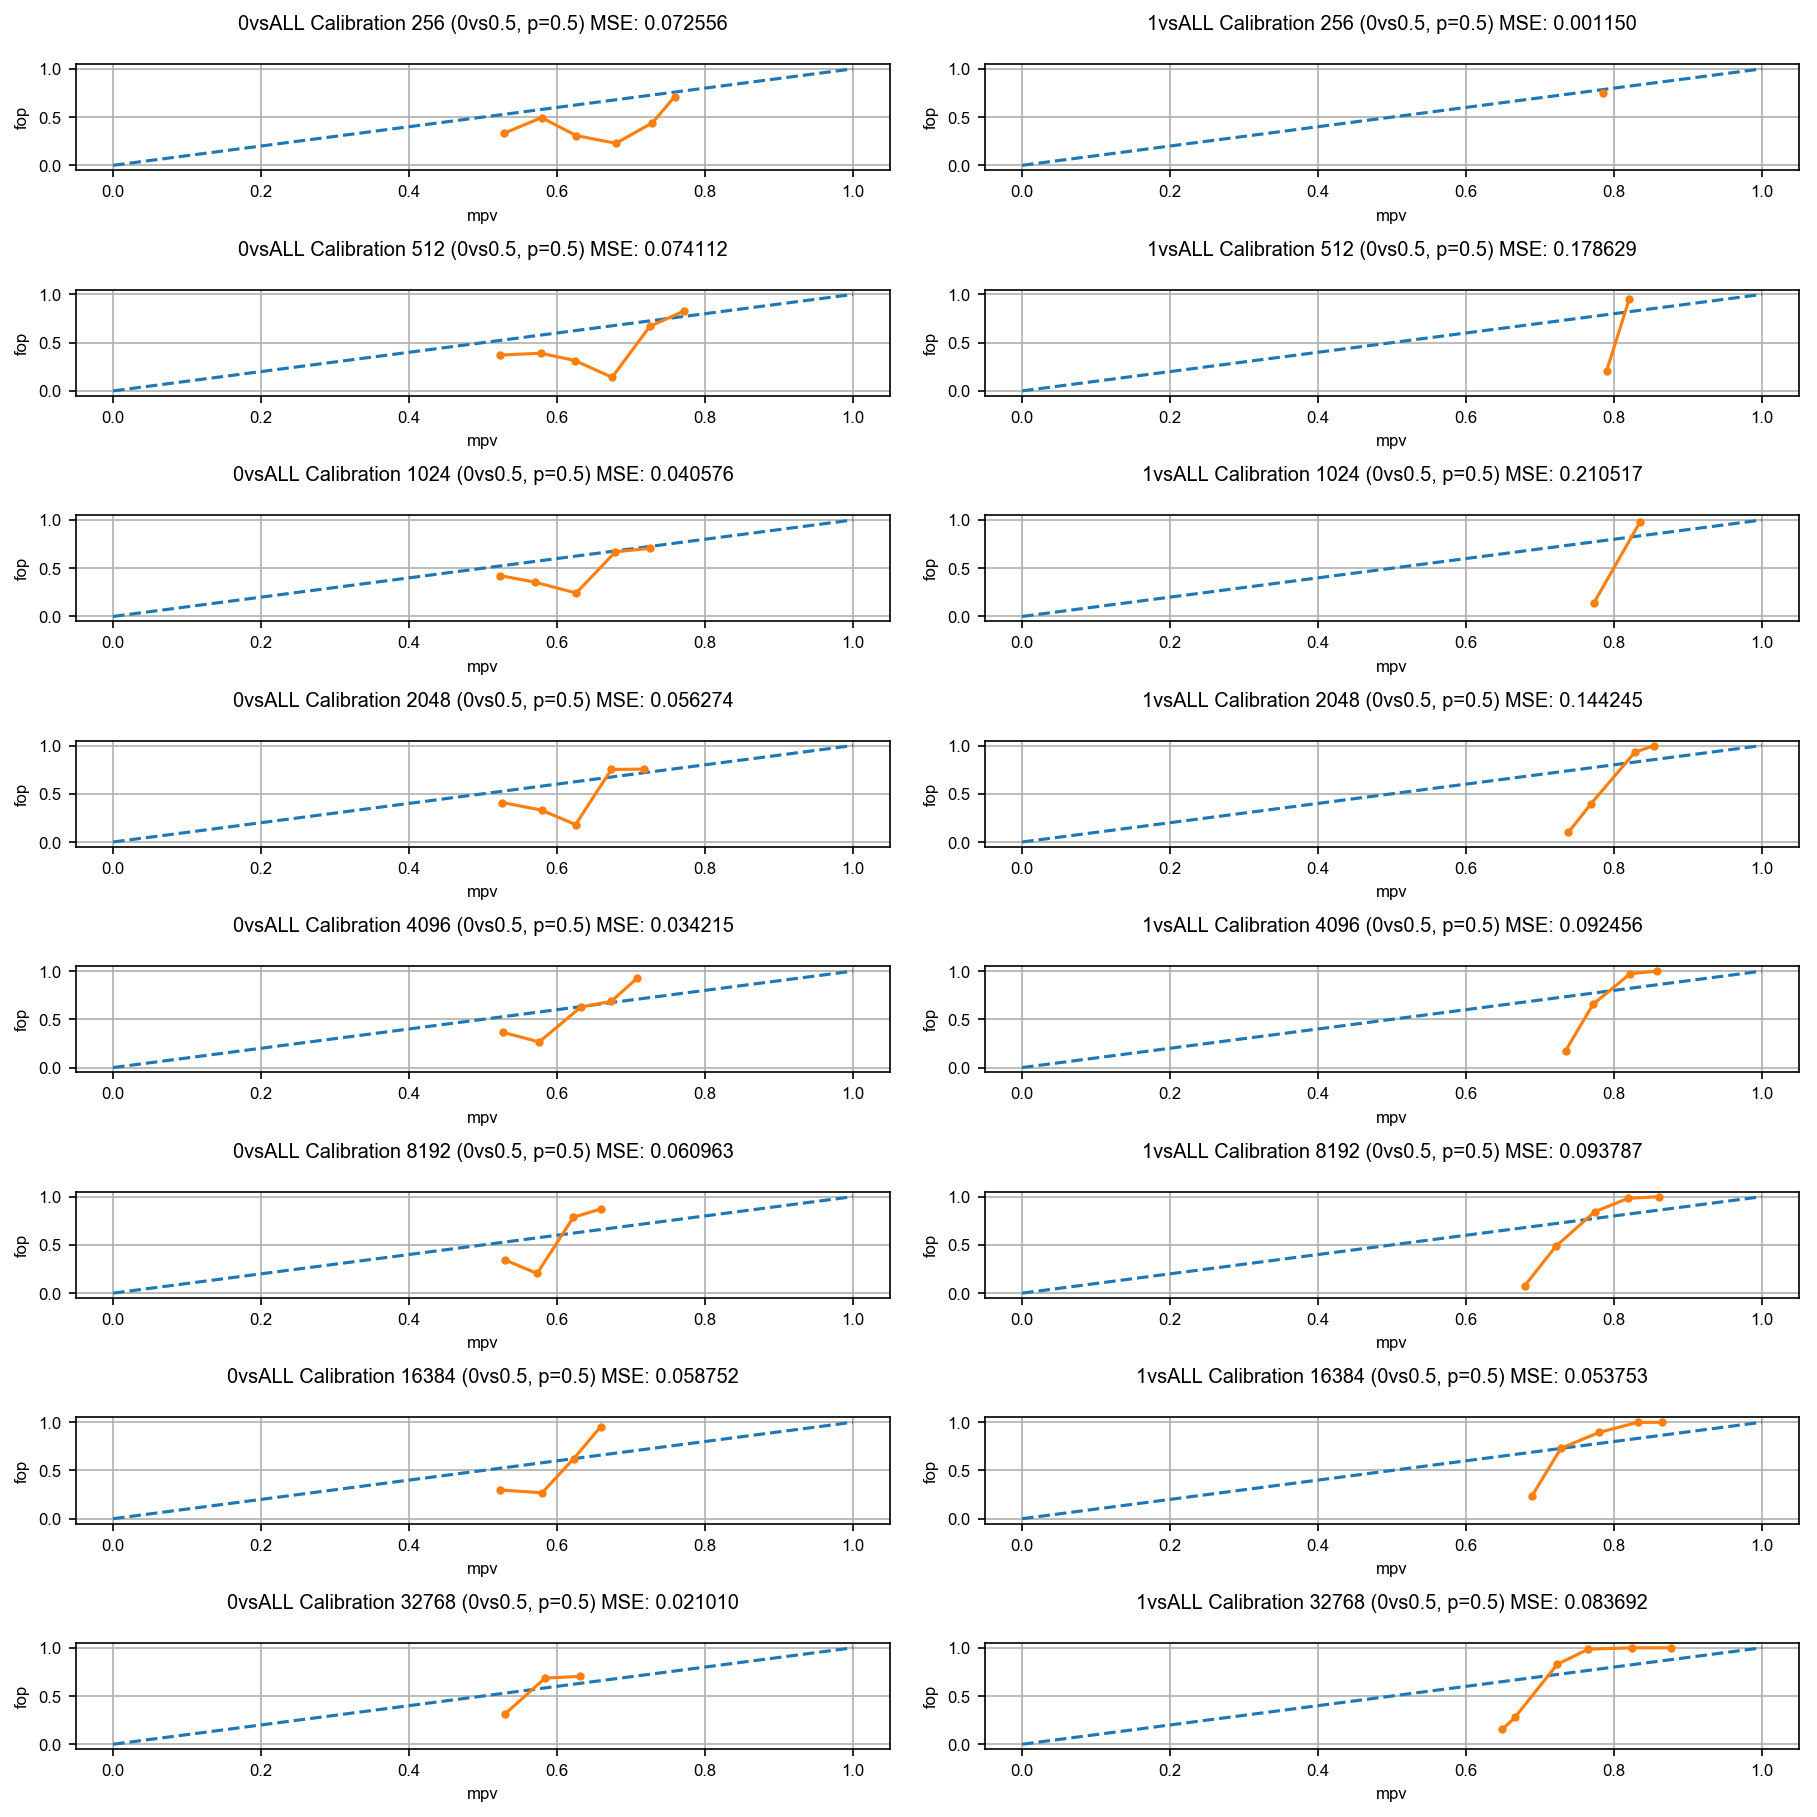

In [33]:
print('Inspecting calibration of intermediate scores [0.5, best_threshold TSet]')
print()


new_thresholds = th_scores.loc[:, th_scores.columns[1]].values

from sklearn.calibration import calibration_curve
with plotparams({'figure.figsize': (12, 12), 'font.size': 8, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(len(labels), 2)  #, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    
    for i, _score_df in enumerate(labelled_test_df):

        test_labels = np.copy(labelled_test_df[i].outlier.values)
        test_predictions = np.copy(labelled_test_df[i].predicted_anomaly_score.values)
        # test_labels[(test_labels < 1) & (test_predictions < 0.5)] = 0
        
        
        flt = (test_predictions > 0.5) & (test_predictions < new_thresholds[i])
        y_pred = np.copy(test_predictions[flt])
        y_true = np.copy(test_labels[flt])
        y_true[y_true > 0] = 1
        assert len(y_pred) == len(y_true)
        # ====================
        ax = fig.add_subplot(gs[i, 0])
        ax.plot([0, 1], [0, 1], linestyle='--')
        fop, mpv = calibration_curve(y_true, y_pred, n_bins=20)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        mse = MSE(mpv, fop)
        mse_str = ''  # str("\n".join(str(_) for _ in zip(mpv, fop)))
        ax.set_title('0vsALL Calibration %s (%s) MSE: %f\n%s' % (str(labels[i]), '0vs0.5, p=0.5', mse, mse_str))
        ax.grid()

        flt = (test_predictions > new_thresholds[i])
        y_pred = np.copy(test_predictions[flt])
        y_true = np.copy(test_labels[flt])
        y_true[y_true != 1] = 0
        assert len(y_pred) == len(y_true)
        # ====================
        ax = fig.add_subplot(gs[i, 1])
        ax.plot([0, 1], [0, 1], linestyle='--')
        fop, mpv = calibration_curve(y_true, y_pred, n_bins=20)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        mse = MSE(mpv, fop)
        mse_str = '' # str("\n".join(str(_) for _ in zip(mpv, fop)))
        ax.set_title('1vsALL Calibration %s (%s) MSE: %f\n%s' % (str(labels[i]), '0vs0.5, p=0.5', mse, mse_str))
        ax.grid()

    plt.show()

In [ ]:
print('Inspecting calibration of intermediate scores [0.5, best_threshold TSet]. Using our version of calibration_curve')
print()

def cal_curve(y_true, y_pred):
    cont = True
    STEP = 0.025
    digits = 2
    mpv, fop = [], []
    y_pred = np.copy(y_pred)
    y_pred[y_pred >= 1] = 0.999
    for min_ in np.arange(0., 1., STEP):
        flt = (y_pred>=min_) & (y_pred<min_+STEP)
        if not np.sum(flt):
            if cont:
                continue
            else:
                break
        cont = False
        y_p = y_pred[flt]
        y_t = y_true[flt]
        mpv.append(min_)
        fop.append(np.true_divide(np.sum(y_t == 1), len(y_t)))
    return np.array(fop, dtype=float), np.array(mpv, dtype=float)
        

new_thresholds = th_scores.loc[:, th_scores.columns[1]].values

from sklearn.calibration import calibration_curve
with plotparams({'figure.figsize': (12, 12), 'font.size': 8, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(len(labels), 2)  #, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    
    for i, _score_df in enumerate(labelled_test_df):

        test_labels = np.copy(labelled_test_df[i].outlier.values)
        test_predictions = np.copy(labelled_test_df[i].predicted_anomaly_score.values)
        # test_labels[(test_labels < 1) & (test_predictions < 0.5)] = 0
        
        
        flt = (test_predictions > 0.5) & (test_predictions < new_thresholds[i])
        y_pred = np.copy(test_predictions[flt])
        y_true = np.copy(test_labels[flt])
        y_true[y_true > 0] = 1
        assert len(y_pred) == len(y_true)
        # ====================
        ax = fig.add_subplot(gs[i, 0])
        ax.plot([0, 1], [0, 1], linestyle='--')
#         fop, mpv = calibration_curve(y_true, y_pred, n_bins=20)
        fop, mpv = cal_curve(y_true, y_pred)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        mse = MSE(mpv, fop)
        mse_str = '' # str("\n".join(str(_) for _ in zip(mpv, fop)))
        ax.set_title('0vsALL Calibration %s (%s) MSE: %f\n%s' % (str(labels[i]), '0vs0.5, p=0.5', mse, mse_str))
        ax.grid()

        flt = (test_predictions > new_thresholds[i])
        y_pred = np.copy(test_predictions[flt])
        y_true = np.copy(test_labels[flt])
        y_true[y_true != 1] = 0
        assert len(y_pred) == len(y_true)
        # ====================
        ax = fig.add_subplot(gs[i, 1])
        ax.plot([0, 1], [0, 1], linestyle='--')
#         fop, mpv = calibration_curve(y_true, y_pred, n_bins=20)
        fop, mpv = cal_curve(y_true, y_pred)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        mse = MSE(mpv, fop)
        mse_str =  '' # str("\n".join(str(_) for _ in zip(mpv, fop)))
        ax.set_title('1vsALL Calibration %s (%s) MSE: %f\n%s' % (str(labels[i]), '0vs0.5, p=0.5', mse, mse_str))
        ax.grid()
    

    plt.show()



In [ ]:
# DALLA LINEA 215 I CUT THESE LINES OF CODE:

# This method returns a score from 0 to 1 indicating the level of anomaly of a segment (wrong inventory, corrupted sensor
#                                                                                      or extremely low/high noise level)
# 

Scores lower than 0.5 do not have particular meanings and denote inliers
scores above 0.5 and 0.755 indicate segments whose ampltudes deviating increasingly from the norm,
but do not indicate singificantly any kind of inventory or sensor error until 0.75:
scores above 0.75 are outliers (inventory errrors, wrong sensors) with a frequency of 96%
(above 0.8 the frequency jumps to 0.99)
 

raise


#         test_labels = np.copy(labelled_test_df[i].outlier.values)
#         test_predictions = np.copy(labelled_test_df[i].predicted_anomaly_score.values)
#         test_labels[(test_labels < 1) & (test_predictions < best_thresholds[i])] = 0
#         flt = (test_predictions > 0.5) & (test_predictions < new_thresholds[i])
#         y_pred = np.copy(test_predictions[flt])
#         y_true = np.copy(test_labels[flt])
#         y_true[y_true > 0] = 1
#         assert len(y_pred) == len(y_true)

#         ax = fig.add_subplot(gs[i, 0])
#         ax.plot([0, 1], [0, 1], linestyle='--')
#         fop, mpv = calibration_curve(y_true, y_pred, n_bins=20)
#         ax.plot(mpv, fop, marker='.')
#         ax.set_xlabel('mpv')
#         ax.set_ylabel('fop')
#         mse = MSE(mpv, fop)
#         ax.set_title('0vsALL Calibration %s (%s) MSE: %f' % (str(labels[i]), '0vs0.5, p=0.5', mse))
#         ax.grid()

#         test_labels = np.copy(labelled_test_df[i].outlier.values)
#         test_predictions = np.copy(labelled_test_df[i].predicted_anomaly_score.values)
#         test_labels[(test_labels >= 1) & (test_predictions < best_thresholds[i])] = 0
#         flt = (test_predictions > 0.5) & (test_predictions < new_thresholds[i])
#         y_pred = np.copy(test_predictions[flt])
#         y_true = np.copy(test_labels[flt])
#         y_true[y_true > 0] = 1
#         assert len(y_pred) == len(y_true)
        
#         ax = fig.add_subplot(gs[i, 0])
#         ax.plot([0, 1], [0, 1], linestyle='--')
#         fop, mpv = calibration_curve(y_true, y_pred, n_bins=20)
#         ax.plot(mpv, fop, marker='.')
#         ax.set_xlabel('mpv')
#         ax.set_ylabel('fop')
#         mse = MSE(mpv, fop)
#         ax.set_title('1vsALL Calibration %s (%s) MSE: %f' % (str(labels[i]), '0vs0.5, p=0.5', mse))
#         ax.grid()



norm_types = [
    'none',
    '[scoremin, scoremax] -> [0, 1]',
    '[pathmin, pathmax] -> [0, 1]'
]

NORM_TYPE = norm_types[2]

def normscores(scores, clf_index):
    i = clf_index
    if NORM_TYPE == norm_types[0]:
        return scores
    if NORM_TYPE == norm_types[1]:
        return (scores - min_psd5scores[i]) / (max_psd5scores[i] - min_psd5scores[i])
    return (np.log2(scores) - np.log2(min_psd5scores[i])) / (np.log2(max_psd5scores[i]) - np.log2(min_psd5scores[i]))

print()
print('PRINTING CALIBRATION. NOTE: scores normalization: %s' % NORM_TYPE)

print()
print('Scores (pseudo) calibration')
from sklearn.calibration import calibration_curve
with plotparams({'figure.figsize': (12, 12), 'font.size': 8, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(len(labels), 2)  #, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    
    for i, score_df in enumerate(scores_df):
        # all vs 1:
        ax = fig.add_subplot(gs[i, 0])
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true < 1] = 0
        ax.plot([0, 1], [0, 1], linestyle='--')
        fop, mpv = calibration_curve(y_true, y_pred2, n_bins=20)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        ax.set_title('%s (%s)' % (str(labels[i]), 'ALLvs1, p=1'))
        ax.grid()
        
        
        # 0 vs 0.5:
        ax = fig.add_subplot(gs[i, 1])
        score_df = score_df[score_df.y_true<1]
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true >= 0.5] = 1
        ax.plot([0, 1], [0, 1], linestyle='--')
        fop, mpv = calibration_curve(y_true, y_pred2, n_bins=20)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        mse = MSE(mpv, fop)
        ax.set_title('%s (%s) MSE: %f' % (str(labels[i]), '0vs0.5, p=0.5', mse))
        ax.grid()

    plt.show()

print()
print('Distributions of different classes')
with plotparams({'figure.figsize': (12, 12), 'font.size': 6, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    bins = np.arange(0.4, .9, 0.01) if NORM_TYPE == norm_types[0] else np.arange(0, 1.1, 0.1)
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(len(labels), 2)  #, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    for i, score_df in enumerate(scores_df):
    
        # all vs 1:
        ax = fig.add_subplot(gs[i, 0])
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true < 1] = 0
        ax.hist([y_pred2[y_true<1], y_pred2[y_true>=1]], rwidth=.75, bins=bins, log=True)  # edgecolor='white', linewidth=3, bins=bins)
        ax.set_xlabel('score')
        ax.set_ylabel('count')
        ax.set_title('Allvs1 %s' % (str(labels[i])))
        ax.grid()
        
        
        # 0 vs 0.5:
        ax = fig.add_subplot(gs[i, 1])
        score_df = score_df[score_df.y_true<1]
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true >= 0.5] = 1
        ax.hist([y_pred2[y_true<1], y_pred2[y_true>=1]], rwidth=.75, bins=bins, log=True)  # edgecolor='white', linewidth=3, bins=bins)
        ax.set_xlabel('score')
        ax.set_ylabel('count')
        ax.set_title('0vs0.5 %s' % (str(labels[i])))
        ax.grid()

#        setlim(axs_, x=True, y=True)
    plt.show()